In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybedtools
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
from torchsummary import summary
import logging
from torch import autograd
from torch import optim
import pprint
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
import editdistance
import argparse
import json
import datetime
import pickle as pk

In [ ]:
!pip install pybedtools
!pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, model_size):
        super(ResBlock, self).__init__()
        self.res_block = nn.Sequential(nn.ReLU(True),
                                       nn.Conv1d(model_size, model_size, 5, padding=2),
                                       nn.ReLU(True), nn.Conv1d(model_size, model_size, 5, padding=2))

    def forward(self, input):
        output = self.res_block(input)
        return input + 0.3 * output


class G4GANGenerator(nn.Module):
    def __init__(
            self,
            model_size,
            seq_len,
            onehot_len,
            last_channel_is_prob=False,
    ):
        super(G4GANGenerator, self).__init__()

        self.model_size = model_size
        self.seq_len = seq_len
        self.onehot_len = onehot_len
        self.last_channel_is_prob = last_channel_is_prob
        self.fc1 = nn.Linear(128, self.model_size * self.seq_len)
        self.block = nn.Sequential(ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size))
        self.conv1 = nn.Conv1d(self.model_size, self.onehot_len, 1)
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise):
        output = self.fc1(noise)
        output = output.view(-1, self.model_size, self.seq_len)
        output = self.block(output)
        output = self.conv1(output)
        output = output.transpose(1, 2)
        shape = output.size()
        output = output.contiguous()
        output = output.view(noise.shape[0] * self.seq_len, -1)
        prob_channel = output.shape[-1]
        if self.last_channel_is_prob:
            prob_channel = -1
            output1 = self.softmax(output[:, :prob_channel])
            output2 = self.sigmoid(output[:, prob_channel]).view(output.shape[0], 1)
            output = torch.cat((output1, output2), 1)
        else:
            output = self.softmax(output)
        return output.view(shape)


class G4GANDiscriminator(nn.Module):
    def __init__(
            self,
            model_size,
            seq_len,
            onehot_len,
    ):
        super(G4GANDiscriminator, self).__init__()
        self.model_size = model_size
        self.seq_len = seq_len
        self.onehot_len = onehot_len
        self.block = nn.Sequential(ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size))
        self.conv1d = nn.Conv1d(self.onehot_len, self.model_size, 1)
        self.linear = nn.Linear(self.seq_len * self.model_size, 1)

    def forward(self, input):
        output = input.transpose(1, 2)
        output = self.conv1d(output)
        output = self.block(output)
        output = output.view(-1, self.seq_len * self.model_size)
        output = self.linear(output)
        return output


def load_g4gan_generator(
        filepath,
        model_size=64,
        ngpus=1,
        num_channels=5,
        latent_dim=100,
        post_proc_filt_len=512,
        upsample=True,
        last_channel_is_prob=True,
        **kwargs
):
    model = G4GANGenerator(
        model_size=model_size,
        ngpus=ngpus,
        num_channels=num_channels,
        latent_dim=latent_dim,
        post_proc_filt_len=post_proc_filt_len,
        upsample=upsample,
        last_channel_is_prob=last_channel_is_prob,
    )
    model.load_state_dict(torch.load(filepath))
    return model


def load_g4gan_discriminator(
        filepath,
        model_size=64,
        ngpus=1,
        num_channels=5,
        shift_factor=2,
        alpha=0.2,
        **kwargs
):
    model = G4GANDiscriminator(model_size=model_size, ngpus=ngpus, num_channels=num_channels,
                               shift_factor=shift_factor, alpha=alpha)
    model.load_state_dict(torch.load(filepath))
    return model


# Save samles method
def save_samples(
        epoch_samples,
        epoch,
        output_dir,
        model_gen,
        model_dis,
        last_channel_is_prob=True,
):
    """
 Save output samples to disk
 """
    sample_dir = output_dir
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)
    samples = np.array(epoch_samples)
    if last_channel_is_prob:
        labels = np.take(samples, -1, axis=2)
        samples = np.delete(samples, -1, axis=2)
    seq = np.argmax(samples, axis=2)
    df = pd.DataFrame(np.take(np.array(list(codes.keys())),
                              indices=seq))
    res = []
    for i in range(len(seq)):
        res.append(np.array(df.iloc[i]))
        if last_channel_is_prob:
            res.append(labels[i])
    res_df = pd.DataFrame(res)
    print(res_df)
    res_path = os.path.join(sample_dir, '{}.csv'.format(epoch))
    res_df.to_csv(res_path, index=False)
    # save model
    model_gen_output_path = os.path.join(sample_dir,
                                         'model_gen_last.pkl')
    model_dis_output_path = os.path.join(sample_dir,
                                         'model_dis_last.pkl')
    torch.save(model_gen.state_dict(), model_gen_output_path,
               pickle_protocol=pk.HIGHEST_PROTOCOL)
    torch.save(model_dis.state_dict(), model_dis_output_path,
               pickle_protocol=pk.HIGHEST_PROTOCOL)


# Wasserstain training process
LOGGER = logging.getLogger('g4gan')
LOGGER.setLevel(logging.DEBUG)


def compute_discr_loss_terms(
        model_dis,
        model_gen,
        real_data_v,
        noise_v,
        batch_size,
        latent_dim,
        lmbda,
        use_cuda,
        use_binary_mask,
        mask_v,
        p_mask,
        compute_grads=False,
        last_channel_is_prob=True,
):
    # Convenient values for
    one = torch.tensor(1, dtype=torch.float)
    neg_one = one * -1
    if use_cuda:
        one = one.cuda()
        neg_one = neg_one.cuda()
    # Reset gradients
    model_dis.zero_grad()
    # Apply binary mask to real data
    if use_binary_mask:
        real_data_v = real_data_v * mask_v * (1 / p_mask)
        if use_cuda:
            real_data_v = real_data_v.cuda()
        real_data_v = autograd.Variable(real_data_v)
    # a) Compute loss contribution from real training data and backprop
    # (negative of the empirical mean, w.r.t. the data distribution, of the discr.output)
    D_real = model_dis(real_data_v)
    D_real = D_real.mean()
    # Negate since we want to _maximize_ this quantity
    if compute_grads:
        D_real.backward(neg_one)
    # b) Compute loss contribution from generated data and backprop
    # (empirical mean, w.r.t. the generator distribution, of the discr. output)
    # Generate noise in latent space
    # Generate data by passing noise through the generator
    fake = autograd.Variable(model_gen(noise_v).data)
    inputv = fake
    # Apply binary mask to fake data
    if use_binary_mask:
        inputv = inputv * mask_v * (1 / p_mask)
        if use_cuda:
            inputv = inputv.cuda()
        inputv = autograd.Variable(inputv)
    D_fake = model_dis(inputv)
    D_fake = D_fake.mean()
    if compute_grads:
        D_fake.backward(one)
    # c) Compute gradient penalty and backprop
    gradient_penalty = calc_gradient_penalty(model_dis,
                                             real_data_v.data,
                                             fake.data,
                                             batch_size,
                                             lmbda,
                                             use_cuda=use_cuda,
                                             )
    if compute_grads:
        gradient_penalty.backward(one)
    # Compute metrics and record in batch history
    D_cost = D_fake - D_real + gradient_penalty
    Wasserstein_D = D_real - D_fake
    return (D_cost, Wasserstein_D)


def compute_gener_loss_terms(
        model_dis,
        model_gen,
        batch_size,
        latent_dim,
        use_cuda,
        use_binary_mask,
        mask_v,
        p_mask,
        compute_grads=False,
        last_channel_is_prob=True,
):
    # Convenient values for
    one = torch.tensor(1, dtype=torch.float)
    neg_one = one * -1
    if use_cuda:
        one = one.cuda()
        neg_one = neg_one.cuda()
    # Reset generator gradients
    model_gen.zero_grad()
    # Sample from the generator
    noise = torch.Tensor(batch_size, latent_dim).uniform_(-1, 1)
    if use_cuda:
        noise = noise.cuda()
    noise_v = autograd.Variable(noise)
    fake = model_gen(noise_v)
    # Apply binary mask to fake data
    if use_binary_mask:
        fake = fake * mask_v * (1 / p_mask)
    if use_cuda:
        fake = fake.cuda()
    # Compute generator loss and backprop
    # (negative of empirical mean (w.r.t generator distribution) of discriminator
    G = model_dis(fake)
    G = G.mean()

    if compute_grads:
        G.backward(neg_one)
    G_cost = -G
    return G_cost


def np_to_input_var(data, use_cuda):
    data = torch.Tensor(data)
    if use_cuda:
        data = data.cuda()
    return autograd.Variable(data)


# Adapted from https://github.com/caogang/wgan-gp/blob/master/gan_toy.py
def calc_gradient_penalty(
        model_dis,
        real_data,
        fake_data,
        batch_size,
        lmbda,
        use_cuda=True,
):
    # Compute interpolation factors
    alpha = torch.rand(batch_size, 1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = (alpha.cuda() if use_cuda else alpha)
    # Interpolate between real and fake data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    if use_cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    # Evaluate discriminator
    disc_interpolates = model_dis(interpolates)
    # Obtain gradients of the discriminator with respect to the inputs
    gradients = autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=(torch.ones(disc_interpolates.size()).cuda() if use_cuda else
                      torch.ones(disc_interpolates.size())),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    # Compute MSE between 1.0 and the gradient of the norm penalty to encourage

    # to be a 1-Lipschitz function
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() \
                       * lmbda
    return gradient_penalty

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, model_size):
        super(ResBlock, self).__init__()
        self.res_block = nn.Sequential(nn.ReLU(True),
                                       nn.Conv1d(model_size, model_size, 5, padding=2),
                                       nn.ReLU(True), nn.Conv1d(model_size, model_size, 5, padding=2))

    def forward(self, input):
        output = self.res_block(input)
        return input + 0.3 * output


class G4GANGenerator(nn.Module):
    def __init__(
            self,
            model_size,
            seq_len,
            onehot_len,
            last_channel_is_prob=False,
    ):
        super(G4GANGenerator, self).__init__()

        self.model_size = model_size
        self.seq_len = seq_len
        self.onehot_len = onehot_len
        self.last_channel_is_prob = last_channel_is_prob
        self.fc1 = nn.Linear(128, self.model_size * self.seq_len)
        self.block = nn.Sequential(ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size))
        self.conv1 = nn.Conv1d(self.model_size, self.onehot_len, 1)
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise):
        output = self.fc1(noise)
        output = output.view(-1, self.model_size, self.seq_len)
        output = self.block(output)
        output = self.conv1(output)
        output = output.transpose(1, 2)
        shape = output.size()
        output = output.contiguous()
        output = output.view(noise.shape[0] * self.seq_len, -1)
        prob_channel = output.shape[-1]
        if self.last_channel_is_prob:
            prob_channel = -1
            output1 = self.softmax(output[:, :prob_channel])
            output2 = self.sigmoid(output[:, prob_channel]).view(output.shape[0], 1)
            output = torch.cat((output1, output2), 1)
        else:
            output = self.softmax(output)
        return output.view(shape)


class G4GANDiscriminator(nn.Module):
    def __init__(
            self,
            model_size,
            seq_len,
            onehot_len,
    ):
        super(G4GANDiscriminator, self).__init__()
        self.model_size = model_size
        self.seq_len = seq_len
        self.onehot_len = onehot_len
        self.block = nn.Sequential(ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size),
                                   ResBlock(self.model_size))
        self.conv1d = nn.Conv1d(self.onehot_len, self.model_size, 1)
        self.linear = nn.Linear(self.seq_len * self.model_size, 1)

    def forward(self, input):
        output = input.transpose(1, 2)
        output = self.conv1d(output)
        output = self.block(output)
        output = output.view(-1, self.seq_len * self.model_size)
        output = self.linear(output)
        return output


def load_g4gan_generator(
        filepath,
        model_size=64,
        ngpus=1,
        num_channels=5,
        latent_dim=100,
        post_proc_filt_len=512,
        upsample=True,
        last_channel_is_prob=True,
        **kwargs
):
    model = G4GANGenerator(
        model_size=model_size,
        ngpus=ngpus,
        num_channels=num_channels,
        latent_dim=latent_dim,
        post_proc_filt_len=post_proc_filt_len,
        upsample=upsample,
        last_channel_is_prob=last_channel_is_prob,
    )
    model.load_state_dict(torch.load(filepath))
    return model


def load_g4gan_discriminator(
        filepath,
        model_size=64,
        ngpus=1,
        num_channels=5,
        shift_factor=2,
        alpha=0.2,
        **kwargs
):
    model = G4GANDiscriminator(model_size=model_size, ngpus=ngpus, num_channels=num_channels,
                               shift_factor=shift_factor, alpha=alpha)
    model.load_state_dict(torch.load(filepath))
    return model


# Save samles method
def save_samples(
        epoch_samples,
        epoch,
        output_dir,
        model_gen,
        model_dis,
        last_channel_is_prob=True,
):
    """
 Save output samples to disk
 """
    sample_dir = output_dir
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)
    samples = np.array(epoch_samples)
    if last_channel_is_prob:
        labels = np.take(samples, -1, axis=2)
        samples = np.delete(samples, -1, axis=2)
    seq = np.argmax(samples, axis=2)
    df = pd.DataFrame(np.take(np.array(list(codes.keys())),
                              indices=seq))
    res = []
    for i in range(len(seq)):
        res.append(np.array(df.iloc[i]))
        if last_channel_is_prob:
            res.append(labels[i])
    res_df = pd.DataFrame(res)
    print(res_df)
    res_path = os.path.join(sample_dir, '{}.csv'.format(epoch))
    res_df.to_csv(res_path, index=False)
    # save model
    model_gen_output_path = os.path.join(sample_dir,
                                         'model_gen_last.pkl')
    model_dis_output_path = os.path.join(sample_dir,
                                         'model_dis_last.pkl')
    torch.save(model_gen.state_dict(), model_gen_output_path,
               pickle_protocol=pk.HIGHEST_PROTOCOL)
    torch.save(model_dis.state_dict(), model_dis_output_path,
               pickle_protocol=pk.HIGHEST_PROTOCOL)


# Wasserstain training process
LOGGER = logging.getLogger('g4gan')
LOGGER.setLevel(logging.DEBUG)


def compute_discr_loss_terms(
        model_dis,
        model_gen,
        real_data_v,
        noise_v,
        batch_size,
        latent_dim,
        lmbda,
        use_cuda,
        use_binary_mask,
        p_mask,
        compute_grads=False,
        last_channel_is_prob=True,
):
    # Convenient values for
    one = torch.tensor(1, dtype=torch.float)
    neg_one = one * -1
    if use_cuda:
        one = one.cuda()
        neg_one = neg_one.cuda()
    # Reset gradients
    model_dis.zero_grad()
    # Apply binary mask to real data
    if use_binary_mask:
        real_data_v = real_data_v  * (1 / p_mask)
        if use_cuda:
            real_data_v = real_data_v.cuda()
        real_data_v = autograd.Variable(real_data_v)
    # a) Compute loss contribution from real training data and backprop
    # (negative of the empirical mean, w.r.t. the data distribution, of the discr.output)
    D_real = model_dis(real_data_v)
    D_real = D_real.mean()
    # Negate since we want to _maximize_ this quantity
    if compute_grads:
        D_real.backward(neg_one)
    # b) Compute loss contribution from generated data and backprop
    # (empirical mean, w.r.t. the generator distribution, of the discr. output)
    # Generate noise in latent space
    # Generate data by passing noise through the generator
    fake = autograd.Variable(model_gen(noise_v).data)
    inputv = fake
    # Apply binary mask to fake data
    if use_binary_mask:
        inputv = inputv * (1 / p_mask)
        if use_cuda:
            inputv = inputv.cuda()
        inputv = autograd.Variable(inputv)
    D_fake = model_dis(inputv)
    D_fake = D_fake.mean()
    if compute_grads:
        D_fake.backward(one)
    # c) Compute gradient penalty and backprop
    gradient_penalty = calc_gradient_penalty(model_dis,
                                             real_data_v.data,
                                             fake.data,
                                             batch_size,
                                             lmbda,
                                             use_cuda=use_cuda,
                                             )
    if compute_grads:
        gradient_penalty.backward(one)
    # Compute metrics and record in batch history
    D_cost = D_fake - D_real + gradient_penalty
    Wasserstein_D = D_real - D_fake
    return (D_cost, Wasserstein_D)


def compute_gener_loss_terms(
        model_dis,
        model_gen,
        batch_size,
        latent_dim,
        use_cuda,
        use_binary_mask,
        p_mask,
        compute_grads=False,
        last_channel_is_prob=True,
):
    # Convenient values for
    one = torch.tensor(1, dtype=torch.float)
    neg_one = one * -1
    if use_cuda:
        one = one.cuda()
        neg_one = neg_one.cuda()
    # Reset generator gradients
    model_gen.zero_grad()
    # Sample from the generator
    noise = torch.Tensor(batch_size, latent_dim).uniform_(-1, 1)
    if use_cuda:
        noise = noise.cuda()
    noise_v = autograd.Variable(noise)
    fake = model_gen(noise_v)
    # Apply binary mask to fake data
    if use_binary_mask:
        fake = fake  * (1 / p_mask)
    if use_cuda:
        fake = fake.cuda()
    # Compute generator loss and backprop
    # (negative of empirical mean (w.r.t generator distribution) of discriminator
    G = model_dis(fake)
    G = G.mean()

    if compute_grads:
        G.backward(neg_one)
    G_cost = -G
    return G_cost


def np_to_input_var(data, use_cuda):
    data = torch.Tensor(data)
    if use_cuda:
        data = data.cuda()
    return autograd.Variable(data)


# Adapted from https://github.com/caogang/wgan-gp/blob/master/gan_toy.py
def calc_gradient_penalty(
        model_dis,
        real_data,
        fake_data,
        batch_size,
        lmbda,
        use_cuda=True,
):
    # Compute interpolation factors
    alpha = torch.rand(batch_size, 1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = (alpha.cuda() if use_cuda else alpha)
    # Interpolate between real and fake data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    if use_cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    # Evaluate discriminator
    disc_interpolates = model_dis(interpolates)
    # Obtain gradients of the discriminator with respect to the inputs
    gradients = autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=(torch.ones(disc_interpolates.size()).cuda() if use_cuda else
                      torch.ones(disc_interpolates.size())),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    # Compute MSE between 1.0 and the gradient of the norm penalty to encourage

    # to be a 1-Lipschitz function
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() \
                       * lmbda
    return gradient_penalty

In [ ]:
def train_wgan(
        model_gen,
        model_dis,
        train_gen,
        valid_gen,
        test_data,
        num_epochs,
        batches_per_epoch,
        batch_size,
        output_dir=None,
        lmbda=0.1,
        use_cuda=True,
        discriminator_updates=5,
        epochs_per_sample=10,
        sample_size=20,
        lr=1e-4,
        beta_1=0.5,
        beta_2=0.9,
        latent_dim=100,
        use_knn_score=False,
        knn_score_sample_size=1000,
        knn_score_real_data=None,
        use_binary_mask=False,
        start_p_mask=1,
        mask_end_epoch=100,
        last_channel_is_prob=True,
):
    if use_cuda:
        model_gen = model_gen.cuda()
        model_dis = model_dis.cuda()
    # Initialize optimizers for each model
    optimizer_gen = optim.Adam(model_gen.parameters(), lr=lr,
                               betas=(beta_1, beta_2))
    optimizer_dis = optim.Adam(model_dis.parameters(), lr=lr,
                               betas=(beta_1, beta_2))
    # Sample noise used for seeing the evolution of generated output samples

    sample_noise = torch.Tensor(sample_size, latent_dim).uniform_(-1, 1)
    if use_cuda:
        sample_noise = sample_noise.cuda()
    sample_noise_v = autograd.Variable(sample_noise)
    samples = {}
    history = []
    plot_history = []
    plot_knn_score_history = []
    train_iter = iter(train_gen)
    valid_iter = iter(valid_gen)
    test_data_v = np_to_input_var(test_data, use_cuda)
    # Sample noise for KNN
    if use_knn_score and knn_score_real_data is not None:
        LOGGER.info('Create KDTree')
        X = np.argmax(knn_score_real_data, 2)

        knn_tree = NearestNeighbors(n_neighbors=2, algorithm='auto',
                                    metric=lambda a, b: \
                                        editdistance.eval(a, b))
        knn_tree.fit(X)
        knn_sample_noise = torch.Tensor(knn_score_sample_size,
                                        latent_dim).uniform_(-1, 1)
        if use_cuda:
            knn_sample_noise = knn_sample_noise.cuda()
        knn_sample_noise_v = autograd.Variable(knn_sample_noise)
        # Score on train data
        (dist, ind) = knn_tree.kneighbors(X[:], 2)
        d_self = np.mean(np.take(dist, 1, axis=1))
        d_train = np.mean(np.take(dist, 0, axis=1))
        LOGGER.info('KNN score on train data:')
        LOGGER.info('D_self: {}'.format(d_self))
        LOGGER.info('D_train: {}'.format(d_train))
        Y = np.argmax(test_data, 2)
        knn_self_tree = NearestNeighbors(n_neighbors=2, algorithm='auto'
                                         , metric=lambda a, b: editdistance.eval(a, b))
        knn_self_tree.fit(Y)
        (dist, ind) = knn_self_tree.kneighbors(Y[:], 2)
        d_self = np.mean(np.take(dist, 1, axis=1))
        (dist, ind) = knn_tree.kneighbors(Y[:], 1)
        d_train = np.mean(np.take(dist, 0, axis=1))
        LOGGER.info('KNN score on test data:')
        LOGGER.info('D_self: {}'.format(d_self))
        LOGGER.info('D_train: {}'.format(d_train))
        best_self_knn_score = 0
    # Set p_mask
    p_mask = None
    if use_binary_mask:
        p_mask = start_p_mask
        LOGGER.info('Setup p_mask: {}'.format(p_mask))
     

    # Loop over the dataset multiple times
    for epoch in range(num_epochs):
        LOGGER.info('Epoch: {}/{}'.format(epoch + 1, num_epochs))
        epoch_history = []
        for batch_idx in range(batches_per_epoch):
            # Set model parameters to require gradients to be computed and stored
            for p in model_dis.parameters():
                p.requires_grad = True
            # Initialize the metrics for this batch
            batch_history = {'discriminator': [], 'generator': {}}
            # Discriminator Training Phase:

            # -> Train discriminator k times
            for iter_d in range(discriminator_updates):
                # Get real examples
                real_data_v = np_to_input_var(next(train_iter),
                                              use_cuda)
                # Get valid examples
                valid_data_v = np_to_input_var(next(valid_iter),
                                               use_cuda)
                # Get noise
                noise = torch.Tensor(batch_size, latent_dim).uniform_(-1, 1)
                if use_cuda:
                    noise = noise.cuda()
                noise_v = autograd.Variable(noise, volatile=True)  # totally freeze model_gen
    # Get new batch of real training data
    (D_cost_train, D_wass_train) = compute_discr_loss_terms(
        model_dis,
        model_gen,
        real_data_v,
        noise_v,
        batch_size,
        latent_dim,
        lmbda,
        use_cuda,
        use_binary_mask,
        p_mask,
        compute_grads=True,
        last_channel_is_prob=last_channel_is_prob,
    )
    # Update the discriminator
    optimizer_dis.step()
    (D_cost_valid, D_wass_valid) = compute_discr_loss_terms(
        model_dis,
        model_gen,
        valid_data_v,
        noise_v,
        batch_size,
        latent_dim,
        lmbda,
        use_cuda,
        use_binary_mask,
        p_mask,
        compute_grads=False,
        last_channel_is_prob=last_channel_is_prob,
    )
    if use_cuda:
        D_cost_train = D_cost_train.cpu()
        D_cost_valid = D_cost_valid.cpu()
        D_wass_train = D_wass_train.cpu()
        D_wass_valid = D_wass_valid.cpu()

    batch_history['discriminator'].append({
        'cost': np.asscalar(D_cost_train.data.numpy().astype(float)),
        'wasserstein_cost':
            np.asscalar(D_wass_train.data.numpy().astype(float)),
        'cost_validation':
            np.asscalar(D_cost_valid.data.numpy().astype(float)),
        'wasserstein_cost_validation':
            np.asscalar(D_wass_valid.data.numpy().astype(float)),
    })
    # ###########################
    # (2) Update G network
    # ##########################
    # Prevent discriminator from computing gradients, since
    # we are only updating the generator
    for p in model_dis.parameters():
        p.requires_grad = False
    G_cost = compute_gener_loss_terms(
        model_dis,
        model_gen,
        batch_size,
        latent_dim,
        use_cuda,
        use_binary_mask,
        p_mask,
        compute_grads=True,
        last_channel_is_prob=last_channel_is_prob,
    )
    # Update generator
    optimizer_gen.step()
    if use_cuda:
        G_cost = G_cost.cpu()
    # Record generator loss
    batch_history['generator']['cost'] = \
        np.asscalar(G_cost.data.numpy().astype(float))
    # Record batch metrics
    epoch_history.append(batch_history)
    # Update binary mask
    if use_binary_mask:
        next_epoch = epoch + 1
        p_mask = (1 - start_p_mask) / mask_end_epoch * next_epoch \
                 + start_p_mask

        if next_epoch == mask_end_epoch or p_mask > 1.:
            p_mask = 1.
        LOGGER.info('Update p_mask: {}'.format(p_mask))
    # Record epoch metrics
    history.append(epoch_history)
    LOGGER.info(pprint.pformat(epoch_history[-1]))
    # Plot
    plot_history.append(epoch_history[-1]['discriminator'][-1])
    plot_history[-1]['gen_cost'] = epoch_history[-1]['generator'
    ]['cost']
    pd.DataFrame(plot_history).plot()
    plt.show()
    # Calc KNN score
    if use_knn_score and knn_tree is not None:
        LOGGER.info('Calculate KNN score...')
        # Self KNN score (D_self)
        knn_samp_output = model_gen(knn_sample_noise_v)
        if use_cuda:
            knn_samp_output = knn_samp_output.cpu()
        # One hot
        prob_channel = knn_samp_output.shape[2]
        if last_channel_is_prob:
            prob_channel = -1
        (values, indices) = knn_samp_output[:, :, :
                                                  prob_channel].max(2)
        knn_samp_output[:, :, :prob_channel] = 0
        indices = indices.view(indices.shape[0], indices.shape[1],
                               1)
        knn_samp_output = knn_samp_output.scatter_(2, indices, 1)
        knn_samp_output = knn_samp_output.data.numpy()
        Y = np.argmax(knn_samp_output, 2)
        knn_self_tree = NearestNeighbors(n_neighbors=2,
                                         algorithm='auto', metric=lambda a, b: \
                editdistance.eval(a, b))
        knn_self_tree.fit(Y)
        (dist, ind) = knn_self_tree.kneighbors(Y[:], 2)
        d_self = np.mean(np.take(dist, 1, axis=1))
        # Train KNN score
        (dist, ind) = knn_tree.kneighbors(Y[:], 1)
        d_train = np.mean(np.take(dist, 0, axis=1))
        # History and plot
        LOGGER.info('D_self: {}'.format(d_self))
        LOGGER.info('D_train: {}'.format(d_train))
        plot_knn_score_history.append({'d_self': d_self,
                                       'd_train': d_train})
        pd.DataFrame(plot_knn_score_history).plot()

        plt.show()
        # Save best knn self score model
        if output_dir and d_self > best_self_knn_score:
            best_self_knn_score = d_self
            # save model
            model_gen_output_path = os.path.join(output_dir,

                                                 'model_gen_best_knn_self_{}.pkl'.format(int(best_self_knn_score)))
            model_dis_output_path = os.path.join(output_dir,

                                                 'model_dis_best_knn_self_{}.pkl'.format(int(best_self_knn_score)))
            torch.save(model_gen.state_dict(),
                       model_gen_output_path,
                       pickle_protocol=pk.HIGHEST_PROTOCOL)
            torch.save(model_dis.state_dict(),
                       model_dis_output_path,
                       pickle_protocol=pk.HIGHEST_PROTOCOL)
    if (epoch + 1) % epochs_per_sample == 0:
        # Generate outputs for fixed latent samples
        LOGGER.info('Generating samples...')
        samp_output = model_gen(sample_noise_v)
        if use_cuda:
            samp_output = samp_output.cpu()
        samples[epoch + 1] = samp_output.data.numpy()
        if output_dir:
            LOGGER.info('Saving samples...')
            save_samples(
                samples[epoch + 1],
                epoch + 1,
                output_dir,
                model_gen,
                model_dis,
                last_channel_is_prob=last_channel_is_prob,
            )
    # # Get final discriminator loss
    # Get noise
    noise = torch.Tensor(batch_size, latent_dim).uniform_(-1, 1)
    if use_cuda:
        noise = noise.cuda()
    noise_v = autograd.Variable(noise, volatile=True)  # totally freeze generator
    final_discr_metrics = {
        'cost_validation': 0,
        'wasserstein_cost_validation': 0,
        'cost_test': 0,
        'wasserstein_cost_test': 0,
    }
    return model_gen, model_dis, history, final_discr_metrics, samples


# Batch generator

def batch_generator(data, batch_size, shuffle_each_epoch=True):
    indices = np.arange(data.shape[0])
    batch = []
    while True:
        if shuffle_each_epoch:
            np.random.shuffle(indices)
        for i in indices:
            batch.append(i)
            if len(batch) == batch_size:
                yield data[batch]
                batch = []


def create_data_split(
        g4_np_dataset_path,
        valid_ratio,
        test_ratio,
        train_batch_size,
        shuffle_each_epoch=True,
        train_subset_size=100,
):
    data = np.load(g4_np_dataset_path)
    num_g4 = data.shape[0]
    num_valid = int(np.ceil(num_g4 * valid_ratio))
    num_test = int(np.ceil(num_g4 * test_ratio))
    num_train = num_g4 - num_valid - num_test
    assert num_valid > 0
    assert num_test > 0
    assert num_train > 0
    indices = np.arange(num_g4)
    np.random.shuffle(indices)
    train_data_indices = indices[:num_train]
    valid_data_indices = indices[num_train:num_train + num_valid]
    test_data_indices = indices[num_train + num_valid:]
    train_data = data[train_data_indices]
    valid_data = data[valid_data_indices]
    test_data = data[test_data_indices]
    train_gen = batch_generator(train_data, train_batch_size,
                                shuffle_each_epoch)
    valid_gen = batch_generator(valid_data, train_batch_size,
                                shuffle_each_epoch)
    train_subset = None
    if train_subset_size > 0:
        train_subset = train_data[:train_subset_size]
    return (train_gen, valid_gen, test_data, train_subset)


# Log
def init_console_logger(logger, verbose=False):
    # Log to stderr also
    stream_handler = logging.StreamHandler()
    if verbose:
        stream_handler.setLevel(logging.DEBUG)
    else:
        stream_handler.setLevel(logging.INFO)
    formatter = \
        logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'
                          )
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

2023-04-25 12:18:48,966 - g4gan - INFO - Initialized logger.
INFO:g4gan:Initialized logger.
2023-04-25 12:18:48,972 - g4gan - INFO - Saving configurations...
INFO:g4gan:Saving configurations...
2023-04-25 12:18:48,977 - g4gan - INFO - Loading G4 data...
INFO:g4gan:Loading G4 data...
2023-04-25 12:18:49,119 - g4gan - INFO - Creating models...
INFO:g4gan:Creating models...
2023-04-25 12:18:49,178 - g4gan - INFO - G4GANGenerator(
  (fc1): Linear(in_features=128, out_features=16384, bias=True)
  (block): Sequential(
    (0): ResBlock(
      (res_block): Sequential(
        (0): ReLU(inplace=True)
        (1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      )
    )
    (1): ResBlock(
      (res_block): Sequential(
        (0): ReLU(inplace=True)
        (1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (2): ReLU(inplace=True)
        (3): Conv1d(3

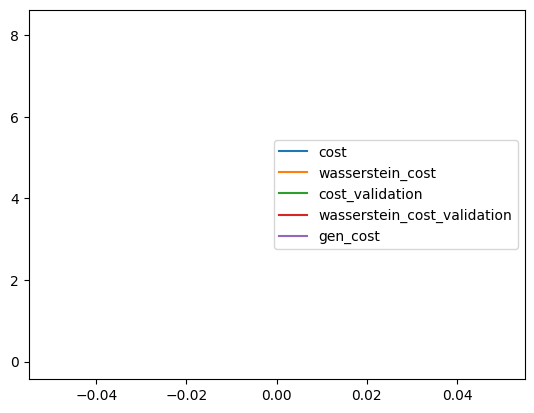

2023-04-25 12:26:15,903 - g4gan - INFO - Calculate KNN score...
INFO:g4gan:Calculate KNN score...
2023-04-25 12:26:17,518 - g4gan - INFO - D_self: 202.91
INFO:g4gan:D_self: 202.91
2023-04-25 12:26:17,525 - g4gan - INFO - D_train: 327.41
INFO:g4gan:D_train: 327.41


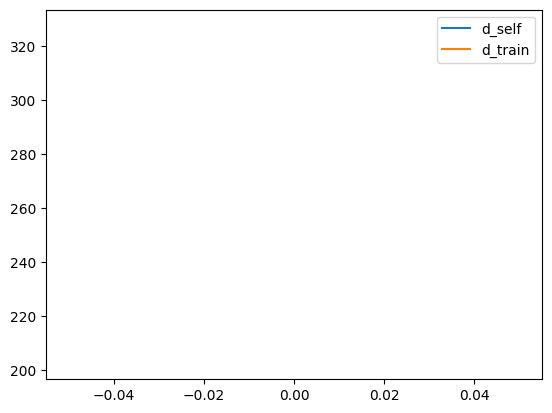

2023-04-25 12:26:17,768 - g4gan - INFO - Generating samples...
INFO:g4gan:Generating samples...
2023-04-25 12:26:17,779 - g4gan - INFO - Saving samples...
INFO:g4gan:Saving samples...
<ipython-input-9-14f7137be74b>:279: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  noise_v = autograd.Variable(noise, volatile=True)  # totally freeze generator
2023-04-25 12:26:17,874 - g4gan - INFO - Finished training.
INFO:g4gan:Finished training.
2023-04-25 12:26:17,878 - g4gan - INFO - Final discriminator loss on validation and test:
INFO:g4gan:Final discriminator loss on validation and test:
2023-04-25 12:26:17,881 - g4gan - INFO - {'cost_test': 0,
 'cost_validation': 0,
 'wasserstein_cost_test': 0,
 'wasserstein_cost_validation': 0}
INFO:g4gan:{'cost_test': 0,
 'cost_validation': 0,
 'wasserstein_cost_test': 0,
 'wasserstein_cost_validation': 0}
2023-04-25 12:26:17,884 - g4gan - INFO - Saving models...
INFO:g4gan:Saving models...
2023-04-25 12:26:17,

         0         1         2         3         4         5         6    \
0          C         N         C         N         N         N         N   
1   0.565237  0.521915  0.558802  0.585062  0.508376  0.579926  0.485593   
2          C         C         C         G         N         C         N   
3    0.50101   0.56391  0.516895  0.562523   0.46555  0.539541  0.497191   
4          N         N         C         C         C         C         C   
5    0.49821  0.530073   0.52147  0.523455  0.486246  0.536692  0.532464   
6          N         C         N         N         N         N         C   
7   0.494064  0.507345  0.533235  0.526975  0.515166   0.51163  0.517465   
8          N         C         N         C         G         C         C   
9   0.596625  0.542371  0.501561  0.523107  0.478076  0.554793  0.533181   
10         C         C         C         C         N         N         G   
11  0.550846  0.510943  0.529528  0.517295  0.548841  0.509957   0.51101   
12         C

In [ ]:
# Train
path = 'G4_Chip_seq_quadruplex_norm_quad_labeled.npy'
channels = 6
last_channel_is_prob = True
# path = 'G4_Chip_seq_quadruplex_norm.npy'
# channels = 5
# last_channel_is_prob = False
args = {}
args['verbose'] = True
args['batches_per_epoch'] = 109
args['batch_size'] = 64
args['latent_dim'] = 128
args['ngpus'] = 1
args['model_size'] = 32
args['output_dir'] = 'models/'
args['g4_np_data_path'] = path
args['valid_ratio'] = 0.1
args['test_ratio'] = 0.1
args['shuffle_train_each_epoch'] = True
args['post_proc_filt_len'] = None
args['alpha'] = 0.2
args['shift_factor'] = 2
args['batch_shuffle'] = False
args['num_epochs'] = 500
args['learning_rate'] = 1e-4
args['beta1'] = 0.5
args['beta2'] = 0.9
args['lmbda'] = 10.0
args['discriminator_updates'] = 5
args['epochs_per_sample'] = 5
args['sample_size'] = 20
args['num_channels'] = channels
args['use_knn_score'] = True
args['knn_score_sample_size'] = 100
args['use_binary_mask'] = False
args['start_p_mask'] = 0.3
args['mask_end_epoch'] = 90
args['last_channel_is_prob'] = last_channel_is_prob
init_console_logger(LOGGER, args['verbose'])
LOGGER.info('Initialized logger.')
batch_size = args['batch_size']
latent_dim = args['latent_dim']
ngpus = args['ngpus']
model_size = args['model_size']
model_dir = os.path.join(args['output_dir'],
                         datetime.datetime.now().strftime('%Y%m%d%H%M%S'
                                                          ))
args['model_dir'] = model_dir
if not args['use_knn_score']:
    args['knn_score_sample_size'] = 0
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
LOGGER.info('Saving configurations...')
config_path = os.path.join(model_dir, 'config.json')
with open(config_path, 'w') as f:
    json.dump(args, f)
LOGGER.info('Loading G4 data...')
g4_np_data_path = args['g4_np_data_path']
(train_gen, valid_gen, test_data, train_subset) = create_data_split(
    g4_np_data_path,
    args['valid_ratio'],
    args['test_ratio'],
    batch_size,
    args['shuffle_train_each_epoch'],
    args['knn_score_sample_size'],
)
LOGGER.info('Creating models...')
model_gen = G4GANGenerator(args['model_size'], 512, args['num_channels'
],
                           last_channel_is_prob=args['last_channel_is_prob'
                           ])
model_dis = G4GANDiscriminator(args['model_size'], 512,
                               args['num_channels'])
LOGGER.info(model_gen)
LOGGER.info(model_dis)
LOGGER.info('Starting training...')
(model_gen, model_dis, history, final_discr_metrics, samples) = \
    train_wgan(
        model_gen=model_gen,
        model_dis=model_dis,
        train_gen=train_gen,
        valid_gen=valid_gen,
        test_data=test_data,
        num_epochs=args['num_epochs'],
        batches_per_epoch=args['batches_per_epoch'],
        batch_size=batch_size,
        output_dir=model_dir,
        lr=args['learning_rate'],
        beta_1=args['beta1'],
        beta_2=args['beta2'],
        lmbda=args['lmbda'],
        use_cuda=ngpus >= 1,
        discriminator_updates=args['discriminator_updates'],
        latent_dim=latent_dim,
        epochs_per_sample=args['epochs_per_sample'],
        sample_size=args['sample_size'],

        use_knn_score=args['use_knn_score'],
        knn_score_sample_size=args['knn_score_sample_size'],
        knn_score_real_data=train_subset,
        use_binary_mask=args['use_binary_mask'],
        start_p_mask=args['start_p_mask'],
        mask_end_epoch=args['mask_end_epoch'],
        last_channel_is_prob=args['last_channel_is_prob'],
    )
LOGGER.info('Finished training.')
LOGGER.info('Final discriminator loss on validation and test:')
LOGGER.info(pprint.pformat(final_discr_metrics))
LOGGER.info('Saving models...')
model_gen_output_path = os.path.join(model_dir, 'model_gen.pkl')
model_dis_output_path = os.path.join(model_dir, 'model_dis.pkl')
torch.save(model_gen.state_dict(), model_gen_output_path,
           pickle_protocol=pk.HIGHEST_PROTOCOL)
torch.save(model_dis.state_dict(), model_dis_output_path,
           pickle_protocol=pk.HIGHEST_PROTOCOL)
LOGGER.info('Saving metrics...')
history_output_path = os.path.join(model_dir, 'history.pkl')
final_discr_metrics_output_path = os.path.join(model_dir,
                                               'final_discr_metrics.pkl')
with open(history_output_path, 'wb') as f:
    pk.dump(history, f)
with open(final_discr_metrics_output_path, 'wb') as f:
    pk.dump(final_discr_metrics, f)
LOGGER.info('Done!')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
from torch.utils import data
import numpy as np
import torch.optim as optim
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [ ]:
weights_path = 'g4gan_big.pkl'
model_size = 32
seq_len = 512
onehot_len = 5
hidden_state_len = 128
g4gan = load_g4gan_generator(weights_path, model_size, seq_len,
 onehot_len)
g4gan.eval()

TypeError: ignored